<a href="https://colab.research.google.com/github/Mena-SA-Kamel/Double-DQN-Sudoku/blob/staging/sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **3547-014 Course Project: Using Double Deep Q-Networks to Solve Sudoku Puzzles**
Mena Kamel, Data Scientist, Bell Canada

Importing all the required libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import time
import csv

Defining the experience replay class. Experience replay dataset is structured as a Deque, where new entries are appended to the end regularly until the data grows to a certain "buffer size" after which older entries are removed.

In [ ]:
class ExperienceReplay:
  '''
  Defining Experience Replay Class
  '''
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size # Defining how big the experience replay dataset is allowed to grow
    self.mask_list = [] # List that stores the mask that highlights the sudoku boxes that have been pre-populated
    self.s_list = [] # List that stores previous sudoku grid contents
    self.a_list = [] # List that stores the action index
    self.r_list = [] # List that stores the obtained rewards
    self.next_s_list = [] # List that stores the next sudoku grid contents
    self.done_list = [] # List that stores the "done" flag indicating if an episode is done or not
    self.num_entries = 0 # Variable storing number of entries in the experience replay dataset

  def add_experience(self, experience):
    '''
    Function that adds an experience to the experience replay dataset
    @experience: list describing an exprience in the form [mask, s, a, r, next_s, done]
    '''
    # Getting the components of an experience
    mask, s, a, r, next_s, done = experience

    # Appending to the end of the experience replay dataset
    self.mask_list += [mask]
    self.s_list += [s]
    self.a_list += [a]
    self.r_list += [r]
    self.next_s_list += [next_s]
    self.done_list += [done]
    self.num_entries += 1

    # If the number of elements in the dataset exceeds the buffer size, we remove the oldest element from the lists
    if self.num_entries > self.buffer_size:
      self.mask_list = self.mask_list[-self.buffer_size:]
      self.s_list = self.s_list[-self.buffer_size:]
      self.a_list = self.a_list[-self.buffer_size:]
      self.r_list = self.r_list[-self.buffer_size:]
      self.next_s_list = self.next_s_list[-self.buffer_size:]
      self.done_list = self.done_list[-self.buffer_size:]
      self.num_entries -= 1

  def draw_sample(self, num_samples):
    '''
    Function that draws num_samples of random entries from the experience replay
    dataset
    @num_samples: integer specifying how many entries to draw
    '''
    # Ensuring the dataset has enough number of samples
    n = np.minimum(num_samples, self.num_entries)
    # Getting indices of random rows, sampled without replacement
    indices = np.random.choice(range(self.num_entries), n, replace=False)
    # Getting the entries at the selected indices
    mask_draw = list(np.array(self.mask_list)[indices])
    s_draw = list(np.array(self.s_list)[indices])
    a_draw = list(np.array(self.a_list)[indices])
    r_draw = list(np.array(self.r_list)[indices])
    next_s_draw = list(np.array(self.next_s_list)[indices])
    done_draw = list(np.array(self.done_list)[indices])
    return mask_draw, s_draw, a_draw, r_draw, next_s_draw, done_draw


Defining the Game environment for Sudoku. The main dataset used is obtained from Kaggle (https://www.kaggle.com/datasets/rohanrao/sudoku), consisting of 9 million Sudoku boards and their solutions. Each entry is a string of numbers, where a 0 indicates an empty box to be filled.

In [ ]:
class Sudoku:
  '''
  Defining the Sudoku Game Environment
  '''
  def __init__(self):
    self.dataset_path = "/content/drive/MyDrive/sudoku_solver/sudoku.csv" # Defining path to .csv
    self.dataset = self.read_dataset(self.dataset_path) # Reading the dataset
    self.valid_move_reward = 5 # Defining the reward obtained for a valid move
    self.done_reward = 1000 # Defining reward for finishing the Sudoku board
    self.invalid_move_penalty = -1 # Invalid move penalty (if a move violates the ruke of the game)
    self.max_allowable_moves = 91 # Max number of actions allowed

  def read_dataset(self, ds_path):
    '''
    Function that reads the dataset .csv file
    '''
    dataset = pd.read_csv(ds_path)
    return dataset

  def new_game(self):
    '''
    Function that resets the environment with a new grid
    '''
    # Drawing a sample from the dataset
    raw_game_data = self.dataset['puzzle'].sample(replace=False).values[0]
    # Converting the string representing the sudoku board to a 2D numpy array
    self.grid = np.array(self.get_game_grid(raw_game_data))
    # Generating a mask that shows which boxes are pre-populated (1) and which ones are empty (0)
    mask = ((self.grid > 0).astype(int))
    # Getting the indices of the filled boxes and storing them in class variable filled_boxes
    immutable_ix = np.where(self.grid != 0)
    self.filled_boxes = list(zip(immutable_ix[0], immutable_ix[1]))
    self.num_actions = 0
    return self.grid, self.filled_boxes, mask

  def get_game_grid(self, raw_game_string):
    '''
    Function to convert Sudoku board represented by a string to a 2D numpy array
    '''
    return np.array(list(raw_game_string)).reshape((9,9)).astype('int')

  def validate_grid(self, grid, allow_zeros=True):
    '''
    Validates the Sudoku board based on the following rules
    1. rows are unique
    2. columns are unique
    3. 3x3 blocks are unique
    @allow_zeros parameter is a flag that allows logic to omit 0 entries
    when validating the grid
    '''
    valid = True
    # Validating rows: Looping through rows making sure all unqiue entries only appear once
    for i in range(9):
      row = grid[i]
      if allow_zeros:
        row = np.delete(row, np.where(grid[i]==0))
      numbers, counts = np.unique(row, return_counts=True)
      valid = valid and np.all(counts <= 1)

    # Validating columns: Looping through columns making sure all unqiue entries only appear once
    for j in range(9):
      column = grid[:,j]
      if allow_zeros:
        column = np.delete(column, np.where(grid[:,j]==0))
      numbers, counts = np.unique(column, return_counts=True)
      valid = valid and np.all(counts <= 1)

    # Validating blocks: Looping through blocks making sure all unqiue entries only appear once
    for row in range(3):
      for col in range(3):
        group = grid[row*3: (row+1)*3, col*3:(col+1)*3].flatten()
        if allow_zeros:
          group = np.delete(group, np.where(group==0))
        numbers, counts = np.unique(group, return_counts=True)
        valid = valid and np.all(counts <= 1)
    # If all conditions hold, at this point valid will be True
    return valid

  def is_done(self, grid):
    '''
    Function to check if board is done.
    '''
    # allow_zeros parameter is False because board is only done when all entries are non zero
    return self.validate_grid(grid, allow_zeros=False)

  def step(self, action, num_actions):
    '''
    Function that updates the Sudoku board given an action
    Returns next grid (ie next state), reward, and done flag
    '''
    # Decoding the action to box (row, column) and number
    box, number = action
    solved = False
    done = False
    # Creating variable to store new grid after we update it with action
    new_grid = self.grid.copy()
    reward = 0
    # If box is one of the ones already pre-populated, penalize agen
    if box in self.filled_boxes:
      reward = -5
    else:
      # Updating the box with the new number
      new_grid[box[0], box[1]] = number
      # Checking if the number does not violate the rules of the game
      valid_grid = self.validate_grid(new_grid)
      if valid_grid:
        # If valid, update the self.grid variable to the new board
        self.grid = new_grid.copy()
        # Give agent positive reward for taking a right move
        reward += self.valid_move_reward
        # Checking if board is solved
        solved = self.is_done(new_grid)
      else:
        # Giving agent penalty for violating rules of the game
        reward = self.invalid_move_penalty
    if solved:
      #If the board is solved give agent large + reward
      reward += self.done_reward
      done = True
    if num_actions == self.max_allowable_moves-1:
      # If we exceed max allowable actions, set done flag to True
      done = True
    return self.grid, reward, done


Defining DQN class to contain logic for Double Deep-Q Network backbone. This architecture involves creating two different feed-forward neural networks: target network and prediction network. The target network is an early copy of the prediction network that is used to generate training targets to compute the loss. A double DQN network architecture used instead of a vanilla DQN network since it does not overestimate the Q values during training.

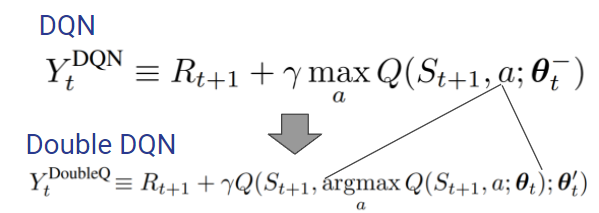

**State components**, shape: [batch size, 162, 1]
1. 1D numpy array of Sudoku grid, shape: [1, 81, 1]
2. 1D numpy array of mask indicating location of prepopulated boxes, shape: [1, 81, 1]

**Actions**, shape: [batch size, 729]
We have 729 total actions, each of the 81 grid locations can take one of the 9 values between 1-9

**Rewards**
*   +1000 points for finishing the game
*    +5 points for predicting a valid move
*   -1 for predicting an invalid move
*   -5 points for attempting to modify one of the prepopulated boxes


In [ ]:
class DQN:
  '''
  Defining the Double DQN class
  Class gets initialized with a Sudoko game object and an ExperienceReplay dataset
  '''
  def __init__(self, game, replay_dataset):
    self.game = game # creating a class variable to store the game object
    self.experience_replay = replay_dataset # Creating a class variable to store experience replay object
    self.num_episodes = 100000 # Number of episodes to train on
    self.num_allowable_actions = 10 # Number of allowable actions in an episode
    self.batch_size = 16 # Batch size
    self.y = 0.95 # Gamma
    self.eps = 0.1 # 0.37 # Epsilone, used to balance between exploration and exploitation
    self.decay_factor = 0.99995 # Decay factor used to control how much exploration is reduced throughout training
    self.model_update_period = 6000 # Number of fwd/backward training iterations after which the target model gets set to prediction model
    self.learning_rate = 0.00005 # Learning rate
    self.pred_network = self.create_network() # Creating prediction network
    self.target_network = self.create_network() # Creating target network
    # model_path = "/content/drive/MyDrive/sudoku_solver/good model - 20220329-204133-UPDATE_PERIOD_6000-LR_5e-05-BATCH_SIZE_16-Y_0.95/20220329-204133_Episode_6500.h5"
    model_path = "/content/drive/MyDrive/sudoku_solver/good model 2 - 20220330-015642-UPDATE_PERIOD_6000-LR_5e-05-BATCH_SIZE_16-Y_0.95/20220330-015642_Episode_29500.h5"
    self.pred_network.load_weights(model_path) # Loading initial model weights
    self.target_network.load_weights(model_path) # Loading initial model weights
    self.models_dir = "/content/drive/MyDrive/sudoku_solver/" # Path to directory where models are saved
    self.time_stamp = time.strftime("%Y%m%d-%H%M%S")
    self.file_name = "{}-UPDATE_PERIOD_{}-LR_{}-BATCH_SIZE_{}-Y_{}".format(self.time_stamp, self.model_update_period, self.learning_rate, self.batch_size, self.y)
    self.model_dir = os.path.join(self.models_dir, self.file_name)
    self.reward_reporting_period = 10 # How often we store the training results to .csv file

  def train_dqn(self):
    '''
    Function to train double DQN network
    '''
    # Making directory to store the model weights
    os.mkdir(self.model_dir)
    # Setting the target network weights to the prediction network weights
    self.target_network.set_weights(self.pred_network.get_weights())
    # Variable to store the number of training steps
    num_train_steps = 0
    reward_log = []
    num_actions_log = []

    # Looping through the episodes
    for i in range(self.num_episodes):
      done = False
      # Getting a new game board
      grid, filled_boxes, mask = self.game.new_game()
      r_sum = 0
      num_actions = 0
      # Decaying epsilone by decay factor--reducing the proportion of exploration
      self.eps *= self.decay_factor
      # Loop while we still have more moves to go and while the game is not solved
      while not done and num_actions < self.num_allowable_actions:
        # Clipping the epsilone so it does not go below 0.1 (always want exploration)
        self.eps = np.maximum(self.eps, 0.1)
        if np.random.random() < self.eps:
          # Picking an action via exploration
          next_move, raw_action = dqn.get_random_move()
        else:
          # Picking an action via exploitation
          # Normalizing the game grid and the mask so they are zero centred
          normalized_grid = (grid/9.0)-0.5
          normalized_mask = mask-0.5
          # Getting the next game move using the prediction network
          next_move, raw_action = dqn.get_next_move(normalized_mask, normalized_grid)
        # Applying the action to the board to get the next grid (state) and reward
        new_grid, reward, done = self.game.step(next_move, num_actions)
        r_sum += reward
        num_actions += 1
        # Formatting experience
        experience = [mask, grid, raw_action, reward, new_grid, done]
        # Adding experience to experience replay dataset
        self.experience_replay.add_experience(experience)

        # If we have enough samples in experience replay, we train
        if self.experience_replay.num_entries >= self.batch_size:
          # Drawing a random batch of experiences from experience replay dataset
          training_data = self.experience_replay.draw_sample(self.batch_size)
          mask_list, s_list, a_list, r_list, next_s_list, done_list = training_data

          # Normalizing the model inputs
          s_list = (np.array(s_list).reshape((self.batch_size, 9*9, 1))/9.0)-0.5
          next_s_list = (np.array(next_s_list).reshape((self.batch_size, 9*9, 1))/9.0)-0.5
          mask_list = np.array(mask_list).reshape((self.batch_size, 9*9, 1))-0.5

          # Constructing the previous and next states by concatenating the game grid and the mask
          s_list = np.concatenate((s_list, mask_list), axis=1)
          next_s_list = np.concatenate((next_s_list, mask_list), axis=1)

          # Getting the index of the next best action using the prediction network
          action_ix = np.argmax(self.pred_network.predict_on_batch(next_s_list), axis=-1)

          # Double DQN uses the target network to get the value at the action index
          #(decoupling argmax operation from value estimation to reduce q-value overestimation)
          action_values = self.target_network.predict_on_batch(next_s_list)

          # Constructing the targer vector
          target_values = action_values[np.arange(self.batch_size), action_ix]
          # Applying the Bellman optimality equation
          targets = r_list + (self.y*target_values * np.logical_not(done_list))
          target_vecs = self.pred_network.predict_on_batch(s_list)
          target_vecs[np.arange(self.batch_size), a_list] = targets

          # Fitting the prediction network to the data
          self.pred_network.fit(s_list, target_vecs, epochs=1, batch_size=self.batch_size, verbose=0)
          num_train_steps += 1

          # Set target network weights to prediction network weights
          if num_train_steps%self.model_update_period == 0:
            print("UPDATED TARGET MODEL")
            self.target_network.set_weights(self.pred_network.get_weights())
        # Setting state = next state
        grid = new_grid.copy()
        self.game.grid = grid

      # Logging some metrics: total episode reward and number of actions taken
      reward_log.append(r_sum)
      num_actions_log.append(num_actions)
      print("EPISODE {} -- R_sum: {}, Num_actions: {}, Epsilone: {}".format(i, r_sum, num_actions, self.eps))
      # Saving metrics to csv file
      if (i+1) % self.reward_reporting_period == 0 and i!=0:
          with open(os.path.join(self.model_dir, '{}_Reward-History.csv'.format(self.time_stamp)), mode='a', newline='') as key_file:
              key_writer = csv.writer(key_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
              for k in range(len(reward_log)):
                  key_writer.writerow([i, reward_log[k], num_actions_log[k], self.eps])
          reward_log = []
          num_actions_log = []
      # Save model weights every 500 episodes
      if i%500 == 0:
        model_name = os.path.join(self.model_dir, "{}_Episode_{}.h5".format(self.time_stamp, i))
        self.pred_network.save_weights(model_name)


  def create_network(self):
    '''
    Defining network structure as a feedforward neural network
    input -> 2048 neurons + ReLu (hidden layer 1) -> 2048 neurons + ReLu (hidden layer 2) -> 729 neurons + Linear activation (output)
    '''
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2048,input_shape=(81*2,), activation='relu'))
    model.add(tf.keras.layers.Dense(2048, activation='relu'))
    model.add(tf.keras.layers.Dense(9*9*9, activation='linear'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

  def get_next_move(self, mask, grid):
    '''
    Gets the next move according to the model
    '''
    input = np.concatenate((grid.reshape(1,9*9,1), mask.reshape(1,9*9,1)), axis=1)
    prediction = self.pred_network.predict(input)
    action_raw = np.argmax(prediction)
    new_pred = prediction.reshape((9,9,9))
    row, column, number = np.where(new_pred==np.max(prediction))
    return ((row[0], column[0]), number[0]+1), action_raw

  def get_random_move(self):
    '''
    Getting a random move
    '''
    actions = np.arange(9*9*9).reshape((9,9,9))
    action_raw = np.random.randint(9*9*9)
    row, column, number = np.where(actions==action_raw)
    return ((row[0], column[0]), number[0]+1), action_raw




# **Training**

Training was done on a total of 35760 episodes. During each episode the agent is allowed to take 10 moves. The total episode reward is recorded for each episode. During training the agent bas a 50-50 chance of exploration and exploitation. As the model learns, the proportion of allowed exploration gradually decreases until it reach 0.1, after which it is clipped.

The following figure shows the training curve. Each blue dot represents an episode. The red curve is the moving average of the total episode reward, computed using the 100-episode window.

The figure below shows that the performance of the agent is steadily increasing and requires additional training cycles to improve in performance.

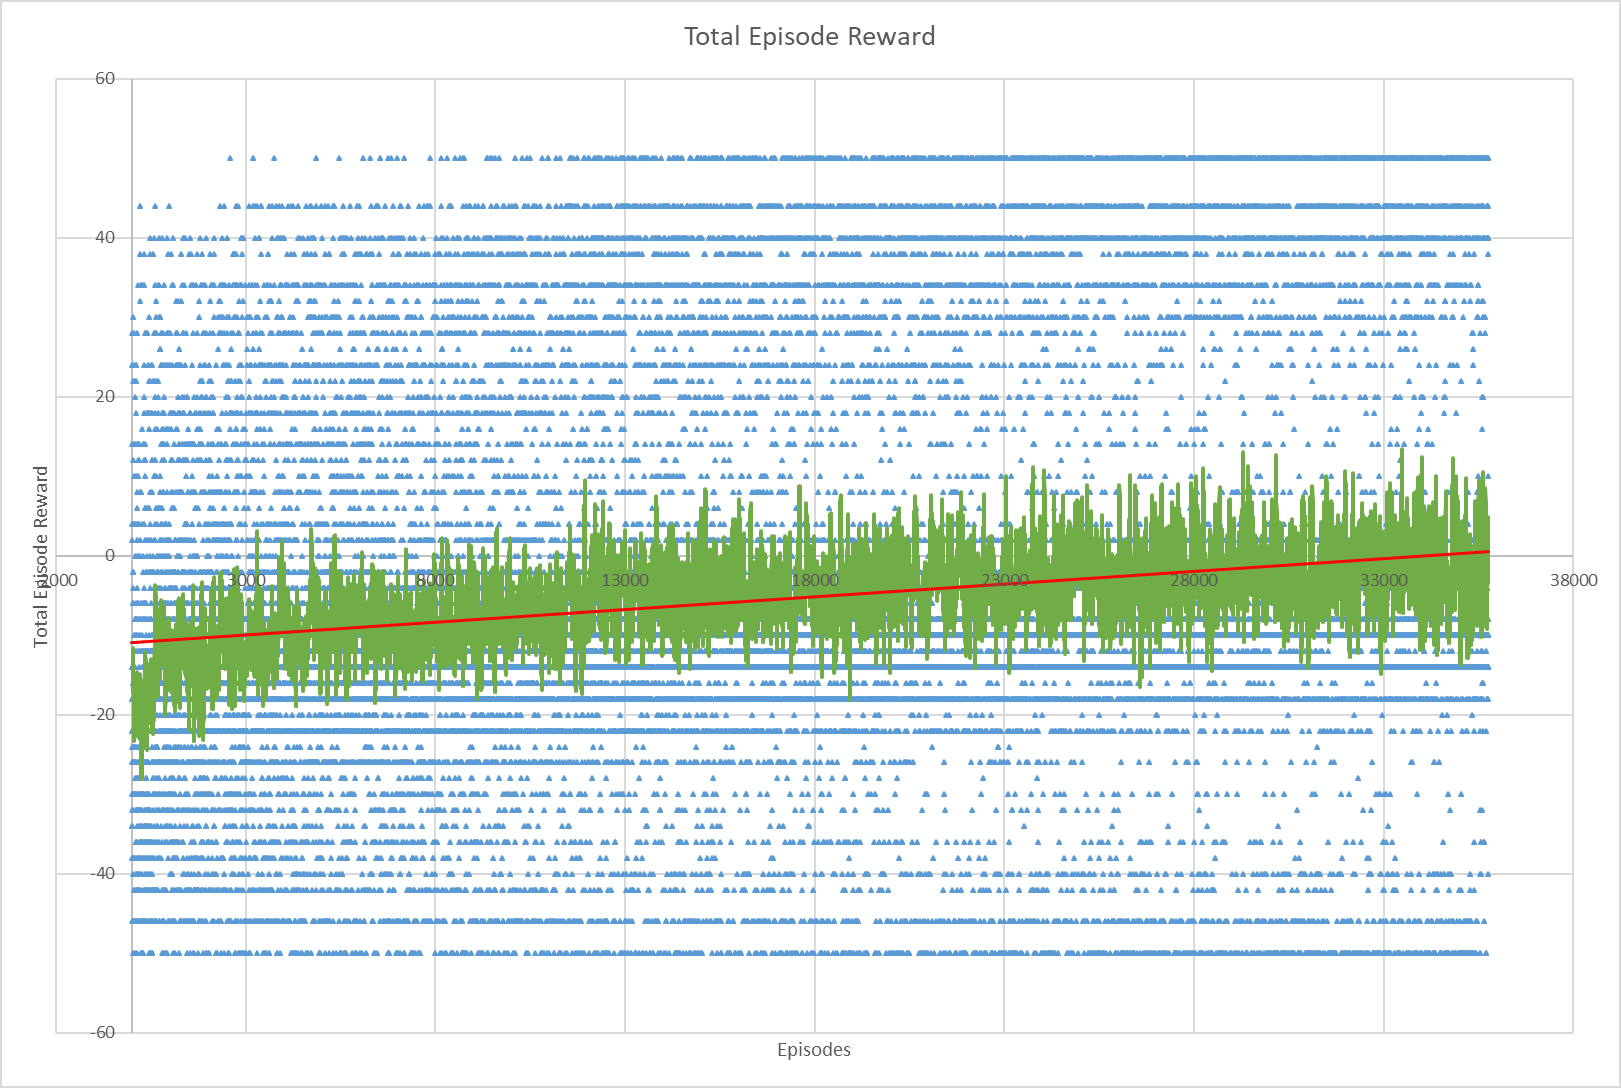
The proportion of expoloration is depicted in the following figure:
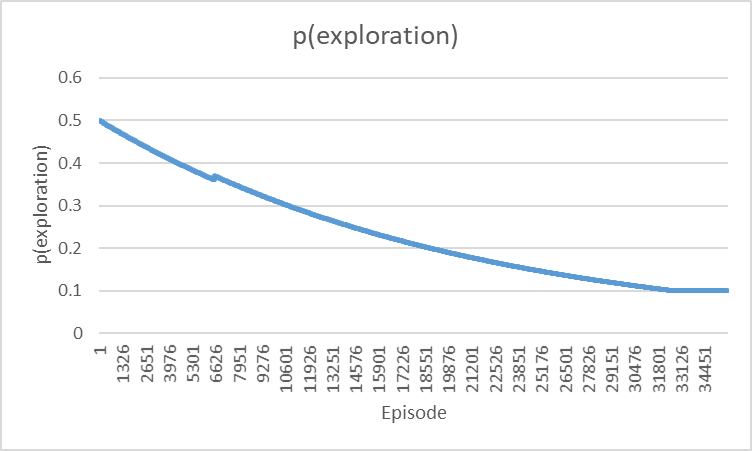


In [ ]:
game = Sudoku()
replay_ds = ExperienceReplay(10000)
dqn = DQN(game, replay_ds)
dqn.train_dqn()

# **Testing**
Testing the algorithm involves running an experiment on 1000 novel episodes of Sudoku. Each game, the agent is allowed to try 10 different actions. A counter increments every time the agent obtains any positive reward (i.e. predicts a valid action). The proportion of valid predictions relative to all predictions is reported as the "correct move rate". The performance of the agent is compared against a random agent that picks actions using a uniform distribution.

The results of ths experiement is summarized below

*   Double DQN: Correct move rate = **0.2240**

*   Random agent: Correct move rate = **0.1469**

In [ ]:
game = Sudoku()
replay_ds = ExperienceReplay(10000)
dqn = DQN(game, replay_ds)

num_eval_samples = 1000
num_allowable_moves = 10
num_correct_predictions = 0
for i in range(num_eval_samples):
  if i%10==0:
    print(i)
  grid, filled_boxes, mask = game.new_game()
  for j in range(num_allowable_moves):
    normalized_grid = (grid/9.0)-0.5
    normalized_mask = mask-0.5
    next_move, raw_action = dqn.get_next_move(normalized_mask, normalized_grid)
    # next_move, raw_action = dqn.get_random_move()
    new_grid, reward, done = game.step(next_move, 1)
    grid = new_grid.copy()
    if reward>0:
      num_correct_predictions += 1
print("Correct Move Proportion: {}".format(num_correct_predictions / (num_eval_samples*num_allowable_moves)))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Correct Move Proportion: 0.2141
